<a href="https://colab.research.google.com/github/Coyote-Schmoyote/pitch-recognition/blob/main/pitch_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
<h1>Pitch Recognition</h1>
<hr>
</center>

# 1. Problem Deifinition
This notebook looks into the implementation of a transfer learning model for pitch recognition. The goal of this project is to familiarize ourselves with the key concepts and some of the libraries when working with audio data.

# 2. Data
The data for this project will be recorded directly in the Goggle Colab Notebook.
The tutorial is an adaptation from TensorFlow's [**Pitch Detection with SPICE**](https://www.tensorflow.org/hub/tutorials/spice).

# 3. Approach
* Import the tools
* Sample audio
* EDA and data visualization
* SPICE model pitch detection
* Convert pitches to notes

# Import the tools

First, we will need to install some libraries that will facilitate audio processing for us.
We will install 5 libraries: `timidity`, `libsndfilel`, `pydub`, `librosa`, and `music21`.

## Timidity
Timidity is a library that converts `.midi` audio file format to `.wav`. Both `.midi` and `.wav` are formats that store sound, however, there are principal differences between the two. `.midi` is the standard format accepted by the music industry, because it captures essential characteristics of music, such as pitch of the note, its volume and length. Essentially, `.midi` files contain instructions for the synthesizer, and not the actual sound, and therefore maintain a relatively small size. 

`.wav`, on the other hand, is an audio file format, used for playback and transfer of music into digital audio workstations. Unlike `.midi` that only contains the description of the sound (pitch, length, volume), `.wav` file contains the actual digitized sound, which makes it more versatile in terms of sounds it can store (including human speech and sound effects), which makes the size of the file very large. 

## Libsndfile
Libsndfile is a library that allows us to read and write files that contain sound in `.wav` and `.aiff` formats.

## PyDub
PyDub is an audio manipulation library that facilitates a number of actions, including slicing, editing the volume, concatenating multiple audio files, playback directly in browser, and save the result. It also supports a variety of audio formats, including `.wav`, `mp3`, `.ogg`, `.flv`, etc.

## Librosa
Librosa is a library designed for music and audio analysis. It provides a number of submodules responsible for different functionalities. For example, `librosa.beat` estimates tempo and detects beat events, `librosa.core` loads audio from disc, computes spectograms, and provides basic tools for music analysis, `librosa.display` provides visualization through `matplotlib`, etc. 

## Music21
Lastly, Music21 provides a toolkit for computational musicology and musical analysis. In our case, we will use `music21` to generate the scores of the detected pitches from the audio input.

In [1]:
!sudo apt-get install -q -y timidity libsndfile1

Reading package lists...
Building dependency tree...
Reading state information...
libsndfile1 is already the newest version (1.0.28-4ubuntu0.18.04.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  freepats libaudio2 timidity-daemon
Suggested packages:
  nas fluid-soundfont-gm fluid-soundfont-gs pmidi
The following NEW packages will be installed:
  freepats libaudio2 timidity timidity-daemon
0 upgraded, 4 newly installed, 0 to remove and 20 not upgraded.
Need to get 29.6 MB of archives.
After this operation, 35.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 freepats all 20060219-1 [29.0 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libaudio2 amd64 1.9.4-6 [50.3 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 timidity amd64 2.13.2-41 [585 kB]
Get:4 http

In [2]:
!pip install pydub librosa music21

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Now let's import the libraries that we installed, as well as out usual tools, such as `numpy`, and `matplotlib`. 

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import librosa
from librosa import display as librosadisplay
import logging
import math
import statistics
import sys
from base64 import b64decode
import music21
from pydub import AudioSegment

print(f"tensorflow: {tf.__version__}")
print(f"librosa: {librosa.__version__}")

tensorflow: 2.8.2
librosa: 0.8.1


# Sampling
For this project, we will use our own data. We will record audio directly from the browser, and use the recorded audio segment for the project. 
GoogleColab provides integration with `javascript` code that enhances the output of a cell. For this, we need to import the `output` module from `google.colab` and `Audio` and `Javascript` from  `IPython.display`. The next bit of code is written in `javascript`, so let's just copy paste it.

In [4]:
from google.colab import output
from IPython.display import Audio, Javascript

In [5]:
RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

Now we can define our recording function. We will run the javascript code from the previous cell and save it in `.wav` format. Then, we will use `base64` module that we imported in the beginning of this notebook.

### Base64
Base64 is the most popular way of encoding information on the web. All the information (text, numbers,  images, audio, etc.) is stored in the computer as a binary code of 0 and 1. What `base64` does is divides the binary information into a groups of 6 untis. Each of these 6 units can be either store a 0 or 1, in other words, there are 2 possible values for each unit. If we take 2 to the power of 6, we get 64, and that's where the name `base64` come from. Base64 essentially creates a table of binary encodings called **ASCII table** that corresponds to the output that we see on the screen: individual characters, pixels, etc, in a format of a base64 string. This ensures that no information is lost or corrputed during transfer.

One of the most common uses of base64 encoding is sending binary data (images, audio, text files, etc.) through HTTP or mail attachments in order to avoid information loss and data corruption. In our case, we will use `b64decode()` method to decode the binary string that we received from our javascript recorder into the normal audio form. 

In [8]:
def record(sec=5):
    print('Recording')
    display(Javascript(RECORD))
    string = output.eval_js('record(%d)' % (sec*1000))
    filename = 'audio.wav'
    print('Saving to', filename)
    blob = b64decode(string.split(',')[1])
    with open(filename, 'wb') as file:
      file.write(blob)
    return filename

Now let's run our `record()` function and record the audio directly in our broswer! This step of the process is called **sampling**.

In [194]:
record()

Recording


<IPython.core.display.Javascript object>

Saving to audio.wav


'audio.wav'

Now that we  have the sample of the audio, we need to convert it to the format our pre-trained model requires: it has to have the sampling rate of 16kHz, and only one channel (mono).
But before we do that, let's try to get a better understanding of what exactly is the sampling rate.

### Sampling rate
Sample rates are typically measured per second, using kilohertz (kHz). Some of the most common sample rates are 46 kHz, 44.1 kHz, and 8 kHz. Most common audio tracks in movies are sampled at 48 kHz, while CDs are usually recorded at 44.1 kHz, which means that every second, 44,100 samples were taken. Telephone communication is sampled at 8kHz, which means that every second, 8,000 samples are taken. The samples need to be taken at precise intervals of time. For example, if the sampling rate is 8,000 samples per second, the samples must be taken at exactly 1/8000 of a second apart. 

So in our case, we need to convert our audio file to have 16,000 samples per second.

We will use `pydub`library to:
 
 * open our recorded `.wav` file using `AudioSegment.from_file()` function
 * change the sample rate to 16kHz using `audio.set_frame_rate()` and change the sound channels to mono with `set_channels()`
 * export the edited file using `audio.export()`

In [196]:
sample_rate = 16000

def convert_audio(file, output_file="converted.wav"):
  audio = AudioSegment.from_file(file)
  audio = audio.set_frame_rate(sample_rate)
  audio = audio.set_channels(1)
  audio.export(output_file, format="wav")
  return output_file

Now let's convert the sound we recorded into the required format  and store it in `converted_audio` variable. We can then extract the `sample_rate` and `audio_samples` from our converted audio file. `"rb"` returns a `wave_read` object.

In [197]:
converted_audio = convert_audio("/content/audio.wav")
type(converted_audio)

str

Now let's listen to our audio using `Audio` module from `IPython.display`.

In [198]:
Audio(converted_audio, rate=sample_rate)

For comparison, this is our sound before we changed the sample rate and number of channels:

In [199]:
AudioSegment.from_file("/content/audio.wav")

# EDA
Now let's familiarize ourselves with the data. 
There are two popular modules that can help us analyze audio data: Python's built-in module `wave` and scipy's module `wavfile`. We will demonstrate how to explore the data using both methods.

In [200]:
import wave

raw = wave.open(converted_audio, "rb")
frequency = raw.getframerate()
n_samples = raw.getnframes()
n_channels = raw.getnchannels()
duration = n_samples/frequency


print(f"Sample frequency: {frequency} Hz")
print(f"Number of Samples: {n_samples}")
print(f"Number of Channels: {n_channels} channel")
print(f"Duration: {duration} seconds")
print(f"Wav_object datatype: {type(raw)}")

Sample frequency: 16000 Hz
Number of Samples: 78720
Number of Channels: 1 channel
Duration: 4.92 seconds
Wav_object datatype: <class 'wave.Wave_read'>


In [201]:
raw.getparams()

_wave_params(nchannels=1, sampwidth=4, framerate=16000, nframes=78720, comptype='NONE', compname='not compressed')

Now let's try to extract the same information using `scipy`.

In [202]:
from scipy.io import wavfile

sample_rate, audio_samples = wavfile.read(converted_audio, "rb")

duration = len(audio_samples)/sample_rate

print(f"Sample rate: {sample_rate} Hz")
print(f"Total duration: {duration} seconds")
print(f"Size of input: {len(audio_samples)}")

Sample rate: 16000 Hz
Total duration: 4.92 seconds
Size of input: 78720


## Visualization
Sound visualization can be a helpful way of getting acquaintaed with our sound data. 
Let's visualize our sound data using two plots: a **waveform** and a **spectrogram** using `matplotlib`.

**Waveform** displays changes in a signal's amplitude over time, while **spectrogram** displays changed in the frequencies of a signal over time, and amplitude is represented by the brightness of the color. Let's plot both and compare them!

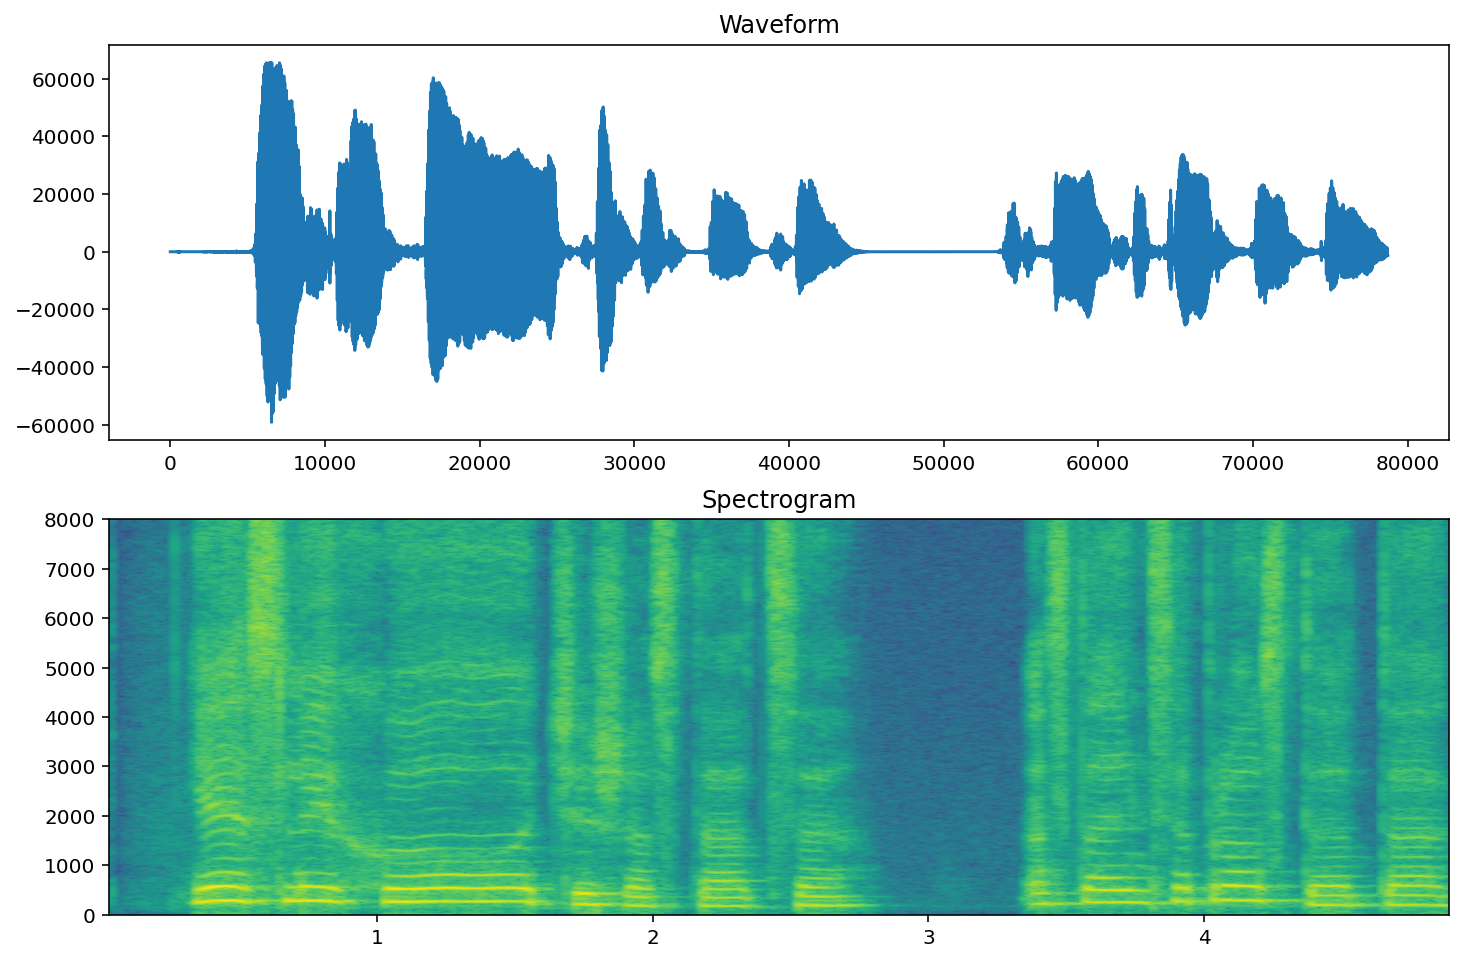

In [234]:
fig, axs = plt.subplots(2, figsize=(12, 8))
axs[0].plot(audio_samples)
axs[0].set_title("Waveform")
axs[1].specgram(audio_samples, NFFT=1024, Fs=sample_rate, noverlap=900)
axs[1].set_title("Spectrogram");

### Short-time Fourier Transform
Another way to plot sound is by visualizing the so-called **power spectrogram**. It plots the power of a signal (in dB) over time, for a given range of frequencies (in Hz). To plot this data, we need to apply a mathematical technique called **Fourier Transform** that is used for converting time domain to frequency domain. 

### Fourier Transform
The Fourier Transform process is like the musician hearing a tone in a symphony and determining what note is being played. The result of this process is called a spectrum. For example, in engineering, we can separate earthquake vibrations into vibrations of different speeds and amplitudes to help design earthquake-resistant buildings. In music production, sound waves can be separated into bass and treble frequencies to boost the parts that we like and hide the parts that we don‘t like. For signal digitization, we use a variation of the Fourier transform, known as the **Discrete Fourier Transform**. Discrete Fourier Transform decomposes a discrete signal into a sum of trigonometric functions, such as transforming the time domain to the frequency domain. It converts a signal sequence of equally-spaced samples into a same-length sequence of time spikes. 

Humans can only hear a very limited range of frequencies, so we cannot visualize it with a Fourier transform well. Human perception of the amplitude of a sound is loudness, which is measured in decibels, so if we make an adjustment to the Fourier transform by transforming frequency to a log scale (non-linear scale), and amplitude to decibels, we can get a spectrogram.

To compute the power spectrogram, we will implement a **Short-time FOurier transform (STFT)** which computes discrete Fourier transforms over short overlapping windows.

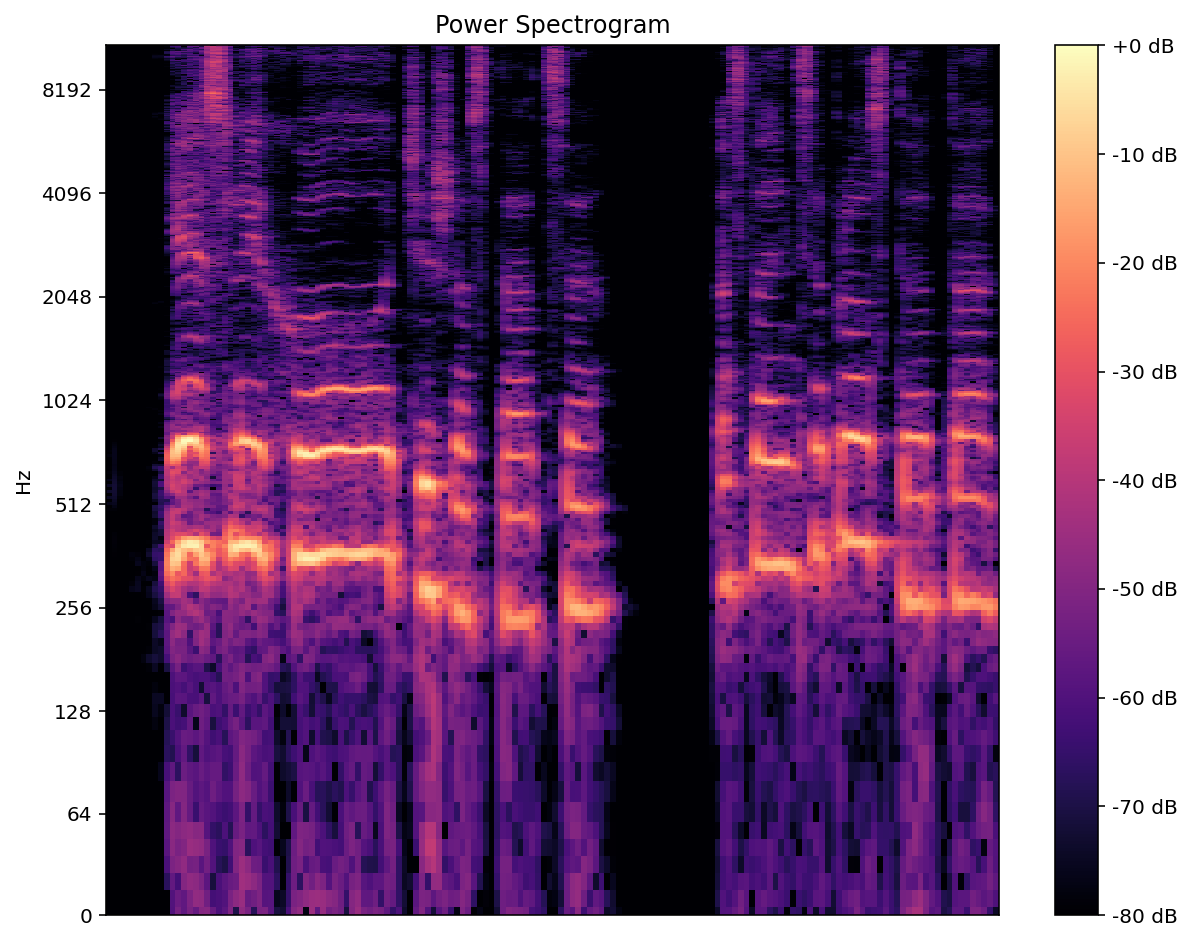

In [204]:
MAX_ABS_INT16 = 32768.0
audio = audio_samples/MAX_ABS_INT16

stft = np.abs(librosa.stft(audio, n_fft=2048))
fig, ax = plt.subplots(1, figsize=(10, 8))
img = librosa.display.specshow(librosa.amplitude_to_db(stft,
                                                       ref=np.max),
                               y_axis="log",  ax=ax)
ax.set_title("Power Spectrogram")
fig.colorbar(img, ax=ax, format="%+2.0f dB");

### Mel Spectrogram

A mel spectrogram is a spectrogram where the frequencies of a signal are converted to the mel scale, in a way that sounds of equal distance from each other also sound equal from each other to the human ear. It takes a spectrogram, and instead of frequency, uses the Mel scale. The general idea behind the Mel scale is that human hearing is more sensitive to low-frequency sounds and relatively insensitive to high-frequency sounds. This means that humans do not perceive frequencies on a linear scale. For instance, we can easily tell the difference between 500 Hz and 1000 Hz, but we normally wouldn‘t be able to tell the difference between 10,000 and 10,500 Hz, even though the distance between the two pairs is the same (500 Hz). 

The purpose of a Mel spectrogram is to provide our machine learning models with sound information similar to what a human would perceive. 


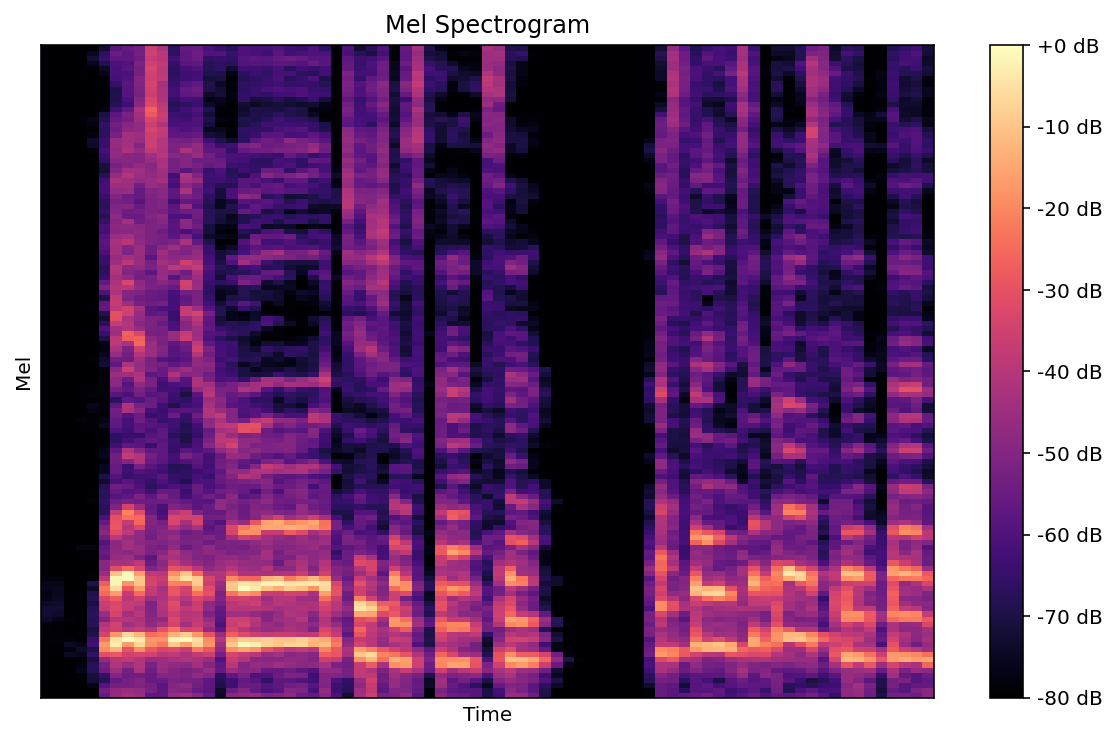

In [238]:
mel_spect = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=2048, hop_length=1024)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)

fig, ax = plt.subplots(1, figsize=(10, 6))
img = librosa.display.specshow(mel_spect, fmax=8000)
ax.set_xlabel("Time")
ax.set_ylabel("Mel")
ax.set_title("Mel Spectrogram")
fig.colorbar(img, ax=ax, format="%+2.0f dB");

# SPICE
SPICE is a pre-trained pitch-extraction model that is used to recognize the dominant pitch in an audio file. It was trained on MIR-1K Dataset, which includes 1000 song clips with singer's voice and accompaniment, recorded at separate channels. 

The model takes raw audio waveform (as a list of floats) as input at 16kHz sampling rate, and outputs two lists of values: `uncertainties` and `pitches`.

### Uncertainties
When we talk about uncertainty in machine learning, we refer to the process of working with imperfect or incomplete information. The main sources of uncertainty in machine learning are noise in observations (or variability in data), incomplete coverage, and imperfect models (and all models are imperfect). 

The SPICE model outputs a list of uncertainties between 0 and 1, each value corresponding with the uncertainty of the model in getting the pitch correctly. `1` means that the model is very confident in its pitch prediction, and `0` means no confidence in the prediction.

### Pitches
The second type of output we get from the SPICE model is `pitches`. `Pitches` represent a list of values in the interval of 0 to 1, and each corresponds with a certain pitch detected in the input audio file.

We will load the model from `TensorFlowHub`, a repository of trained machine learning models, managed by TensorFlow.

We need one last conversion here. The audio samples are in `int16` format. They need to be normalized to floats between -1 and 1.

In [206]:
audio_samples = audio_samples / float(MAX_ABS_INT16)

Let's load the `SPICE` model!

In [207]:
model = hub.load("https://tfhub.dev/google/spice/2")

In [208]:
# We now feed the audio to the SPICE tf.hub model to obtain pitch and uncertainty outputs as tensors.
model_output = model.signatures["serving_default"](tf.constant(audio_samples, tf.float32))

pitch_outputs = model_output["pitch"]
uncertainty_outputs = model_output["uncertainty"]

# 'Uncertainty' basically means the inverse of confidence.
confidence_outputs = 1.0 - uncertainty_outputs

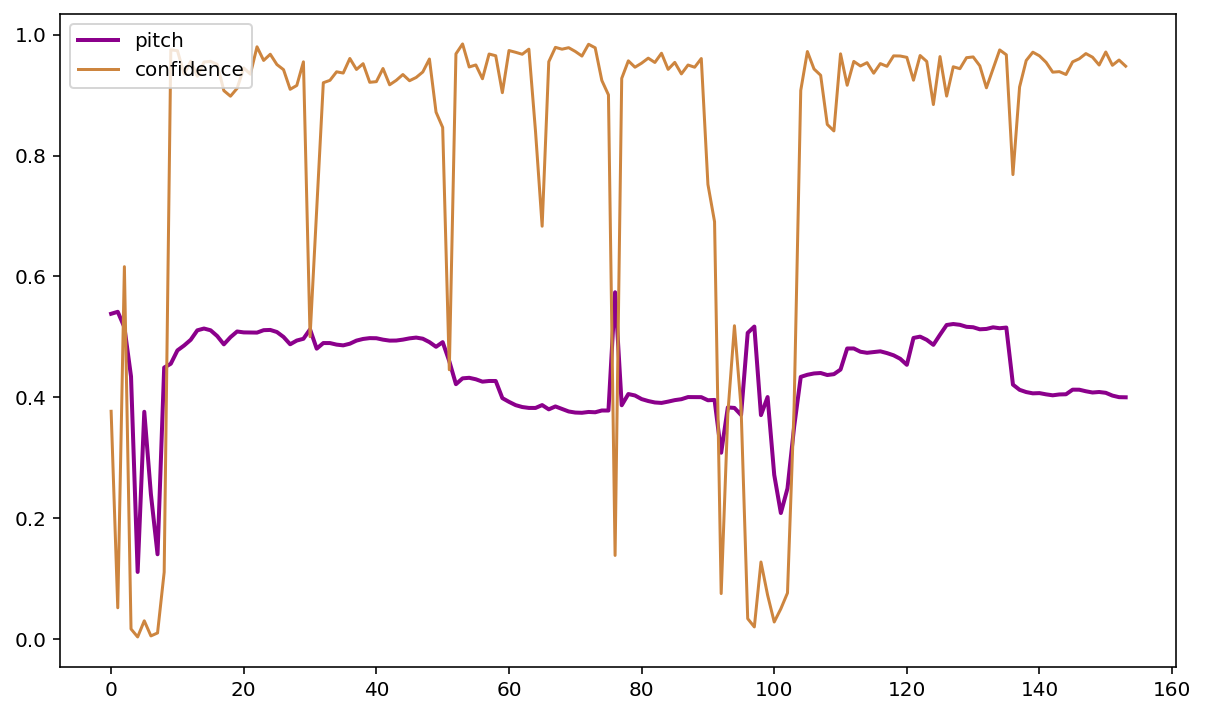

In [209]:
fig, ax = plt.subplots(1, figsize=(10,6))
plt.plot(pitch_outputs, label="pitch", color="darkmagenta", linewidth=2)
plt.plot(confidence_outputs, label="confidence", color="peru")
plt.legend(loc="upper left")
plt.show();

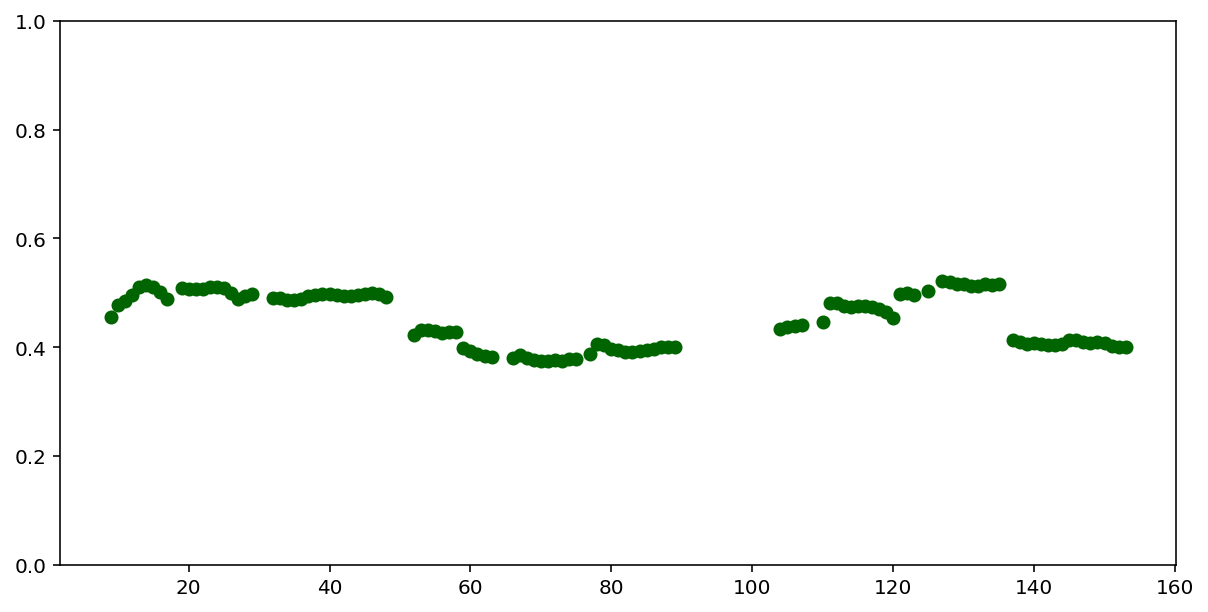

In [210]:
confidence_outputs = list(confidence_outputs)
pitch_outputs = [float(x) for x in pitch_outputs]

indices = range(len(pitch_outputs))
confident_pitch_outputs = [(index, pitch)  
  for index, pitch, confidence in zip(indices, pitch_outputs, confidence_outputs) if  confidence >= 0.9]
confident_pitch_outputs_x, confident_pitch_outputs_y = zip(*confident_pitch_outputs)

fig, ax = plt.subplots(1, figsize=(10,5))
ax.set_ylim([0, 1])
plt.scatter(confident_pitch_outputs_x, confident_pitch_outputs_y, color="darkgreen")

plt.show()

# Convert to notes
Constants taken from https://tfhub.dev/google/spice/2

In [212]:
def output2hz(pitch_output):
  PT_OFFSET = 25.58
  PT_SLOPE = 63.07
  FMIN = 10.0;
  BINS_PER_OCTAVE = 12.0;
  cqt_bin = pitch_output * PT_SLOPE + PT_OFFSET;
  return FMIN * 2.0 ** (1.0 * cqt_bin / BINS_PER_OCTAVE)

confident_pitch_values_hz = [ output2hz(pitch) for pitch in confident_pitch_outputs_y ]

In [213]:
pitch_outputs_and_rests = [
    output2hz(pitch) if confidence >= 0.9 else 0
    for index, pitch, confidence in zip(indices, pitch_outputs, confidence_outputs)
]

In [214]:
A4 = 440
C0 = A4 * pow(2, -4.75)
note_names = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

def hz2offset(freq):
  # This measures the quantization error for a single note.
  if freq == 0:  # Rests always have zero error.
    return None
  # Quantized note.
  h = round(12 * math.log2(freq / C0))
  return 12 * math.log2(freq / C0) - h


# The ideal offset is the mean quantization error for all the notes
# (excluding rests):
offsets = [hz2offset(p) for p in pitch_outputs_and_rests if p != 0]
print("offsets: ", offsets)

ideal_offset = statistics.mean(offsets)
print("ideal offset: ", ideal_offset)

offsets:  [-0.1984464837485973, 0.19308866755420695, -0.2987696100646673, 0.29969973043854736, 0.2883638556426362, 0.4765451403086942, 0.2927509178345957, -0.3106186245257163, -0.1750315247351466, 0.1678042288249202, 0.07244671420509263, 0.059364472193067286, 0.051300848883940375, 0.3043144168084453, 0.32927217678482634, 0.11271971957142313, -0.40316420896593996, -0.16756938381735864, 0.22289418832715313, 0.4073049302523799, -0.03921492113415326, -0.04058705283944164, -0.20322601183002575, -0.2805503325039638, -0.10768805249279012, 0.2164489285772504, 0.38896723584587534, 0.4751183106129915, 0.46414501623566196, 0.31499805913622225, 0.214298629028157, 0.22333590195829345, 0.3174979703253058, 0.4502131803458411, -0.46874082668367834, 0.4142219777529945, 0.05901843116934913, -0.33359995438401313, 0.27774674819166734, 0.33419962988550367, 0.17957542375977198, -0.0680868305141118, 0.0020930071299716246, 0.0011870242779963291, 0.2130926527207606, -0.1752920459086127, 0.4811788047974801, 0.2

In [215]:
def quantize_predictions(group, ideal_offset):
  # Group values are either 0, or a pitch in Hz.
  non_zero_values = [v for v in group if v != 0]
  zero_values_count = len(group) - len(non_zero_values)

  # Create a rest if 80% is silent, otherwise create a note.
  if zero_values_count > 0.8 * len(group):
    # Interpret as a rest. Count each dropped note as an error, weighted a bit
    # worse than a badly sung note (which would 'cost' 0.5).
    return 0.51 * len(non_zero_values), "Rest"
  else:
    # Interpret as note, estimating as mean of non-rest predictions.
    h = round(
        statistics.mean([
            12 * math.log2(freq / C0) - ideal_offset for freq in non_zero_values
        ]))
    octave = h // 12
    n = h % 12
    note = note_names[n] + str(octave)
    # Quantization error is the total difference from the quantized note.
    error = sum([
        abs(12 * math.log2(freq / C0) - ideal_offset - h)
        for freq in non_zero_values
    ])
    return error, note

In [216]:
def get_quantization_and_error(pitch_outputs_and_rests, predictions_per_eighth,
                               prediction_start_offset, ideal_offset):
  # Apply the start offset - we can just add the offset as rests.
  pitch_outputs_and_rests = [0] * prediction_start_offset + \
                            pitch_outputs_and_rests
  # Collect the predictions for each note (or rest).
  groups = [
      pitch_outputs_and_rests[i:i + predictions_per_eighth]
      for i in range(0, len(pitch_outputs_and_rests), predictions_per_eighth)
  ]

  quantization_error = 0

  notes_and_rests = []
  for group in groups:
    error, note_or_rest = quantize_predictions(group, ideal_offset)
    quantization_error += error
    notes_and_rests.append(note_or_rest)

  return quantization_error, notes_and_rests

In [217]:
best_error = float("inf")
best_notes_and_rests = None
best_predictions_per_note = None

for predictions_per_note in range(20, 65, 1):
  for prediction_start_offset in range(predictions_per_note):

    error, notes_and_rests = get_quantization_and_error(
        pitch_outputs_and_rests, predictions_per_note,
        prediction_start_offset, ideal_offset)

    if error < best_error:      
      best_error = error
      best_notes_and_rests = notes_and_rests
      best_predictions_per_note = predictions_per_note

# At this point, best_notes_and_rests contains the best quantization.
# Since we don't need to have rests at the beginning, let's remove these:
while best_notes_and_rests[0] == 'Rest':
  best_notes_and_rests = best_notes_and_rests[1:]
# Also remove silence at the end.
while best_notes_and_rests[-1] == 'Rest':
  best_notes_and_rests = best_notes_and_rests[:-1]

In [218]:
onset_env = librosa.onset.onset_strength(y=audio_samples, sr=sample_rate)
tempo = librosa.beat.tempo(onset_envelope=onset_env, sr = sample_rate)
tempo

/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


array([133.92857143])

In [227]:
# Creating the sheet music score.
sc = music21.stream.Score()
# Adjust the speed to match the actual singing.
bpm = 134
print ('bpm: ', bpm)
a = music21.tempo.MetronomeMark(number=bpm)
sc.insert(0,a)

for snote in best_notes_and_rests:   
    d = 'half'
    if snote == 'Rest':      
      sc.append(music21.note.Rest(type=d))
    else:
      sc.append(music21.note.Note(snote, type=d))

bpm:  134


In [228]:
from IPython.core.display import display, HTML, Javascript
import json, random

def showScore(score):
    xml = open(score.write('musicxml')).read()
    showMusicXML(xml)

def showMusicXML(xml):
    DIV_ID = "OSMD_div"
    display(HTML('<div id="'+DIV_ID+'">loading OpenSheetMusicDisplay</div>'))
    script = """
    var div_id = %%DIV_ID%%;
    function loadOSMD() { 
        return new Promise(function(resolve, reject){
            if (window.opensheetmusicdisplay) {
                return resolve(window.opensheetmusicdisplay)
            }
            // OSMD script has a 'define' call which conflicts with requirejs
            var _define = window.define // save the define object 
            window.define = undefined // now the loaded script will ignore requirejs
            var s = document.createElement( 'script' );
            s.setAttribute( 'src', "https://cdn.jsdelivr.net/npm/opensheetmusicdisplay@0.7.6/build/opensheetmusicdisplay.min.js" );
            //s.setAttribute( 'src', "/custom/opensheetmusicdisplay.js" );
            s.onload=function(){
                window.define = _define
                resolve(opensheetmusicdisplay);
            };
            document.body.appendChild( s ); // browser will try to load the new script tag
        }) 
    }
    loadOSMD().then((OSMD)=>{
        window.openSheetMusicDisplay = new OSMD.OpenSheetMusicDisplay(div_id, {
          drawingParameters: "compacttight"
        });
        openSheetMusicDisplay
            .load(%%data%%)
            .then(
              function() {
                openSheetMusicDisplay.render();
              }
            );
    })
    """.replace('%%DIV_ID%%',DIV_ID).replace('%%data%%',json.dumps(xml))
    display(Javascript(script))
    return

In [229]:
# rendering the music score
showScore(sc)
print(best_notes_and_rests)

<IPython.core.display.Javascript object>

['C#4', 'C4', 'F#3', 'F#3', 'A#3', 'C#4', 'G3']


In [230]:
# Saving the recognized musical notes as a MIDI file
converted_audio_file_as_midi = converted_audio[:-4] + '.mid'
fp = sc.write('midi', fp=converted_audio_file_as_midi)

In [231]:
wav_from_created_midi = converted_audio_file_as_midi.replace(' ', '_') + "_midioutput.wav"
print(wav_from_created_midi)

converted.mid_midioutput.wav


In [232]:
!timidity $converted_audio_file_as_midi -Ow -o $wav_from_created_midi

Playing converted.mid
MIDI file: converted.mid
Format: 1  Tracks: 1  Divisions: 1024
Sequence: 
Playing time: ~10 seconds
Notes cut: 0
Notes lost totally: 0


In [233]:
Audio(wav_from_created_midi)

# Conclusion